# Ray et al 2013 Extract-Transform-Load
**Authorship:**
Adam Klie, *08/11/2022*
***
**Description:**
Notebook to extract, transform, and load data from the Ray et al (2013) dataset.
***

In [59]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import eugene as eu
eu.settings.dataset_dir = "/cellar/users/aklie/data/eugene"

# Download and load in the dataset to a raw `SeqData` object

In [60]:
# Load in the downloaded data, or download it if it's not there
sdata_raw = eu.datasets.ray13()

Dataset ray13 norm_data.txt.gz has already been dowloaded.


In [61]:
# Subset to set type (A or B)
sdata_setA_raw = sdata_raw[sdata_raw.seqs_annot["Probe_Set"] == "SetA"]
sdata_setB_raw = sdata_raw[sdata_raw.seqs_annot["Probe_Set"] == "SetB"]

In [62]:
# Save raw versions of these three
sdata_raw.write_h5sd(os.path.join(eu.settings.dataset_dir, eu.settings.dataset_dir, "ray13", "norm_raw.h5sd"))
sdata_setA_raw.write_h5sd(os.path.join(eu.settings.dataset_dir, eu.settings.dataset_dir, "ray13", "norm_setA_raw.h5sd"))
sdata_setB_raw.write_h5sd(os.path.join(eu.settings.dataset_dir, eu.settings.dataset_dir, "ray13", "norm_setB_raw.h5sd"))

# Preprocess the training set

## Preprocess the seqs
- Padded elements of sequences are replaced with a one hot encoded value of 0.25 spanning each base.

In [63]:
eu.pp.one_hot_encode_data(sdata_setA_raw, alphabet="RNA", seq_align="center", fill_value=0.25)
eu.pp.one_hot_encode_data(sdata_setB_raw, alphabet="RNA", seq_align="center", fill_value=0.25)

One-hot-encoding sequences:   0%|          | 0/120326 [00:00<?, ?it/s]

SeqData object modified:
	ohe_seqs: None -> 120326 ohe_seqs added


One-hot-encoding sequences:   0%|          | 0/121031 [00:00<?, ?it/s]

SeqData object modified:
	ohe_seqs: None -> 121031 ohe_seqs added


## Preprocess the targets
- The values of probe intensities are clamped at 99.95% percentile per binding protein to eliminate outliers and balance the data.
- The probe intensities are normalized to a mean of 0 and a standard deviation of 1.

In [64]:
# Get a list of only the target columns
target_mask = sdata_setA_raw.seqs_annot.columns.str.contains("RNCMPT")
target_cols = sdata_setA_raw.seqs_annot.columns[target_mask]
random_cols = np.random.choice(target_cols, 9)
len(target_cols)

244

In [65]:
# Split only those training sequences in SetA into train and validation sets
eu.pp.train_test_split_data(sdata_setA_raw, train_key="train_val", split=0.8)

SeqData object modified:
    seqs_annot:
        + train_val


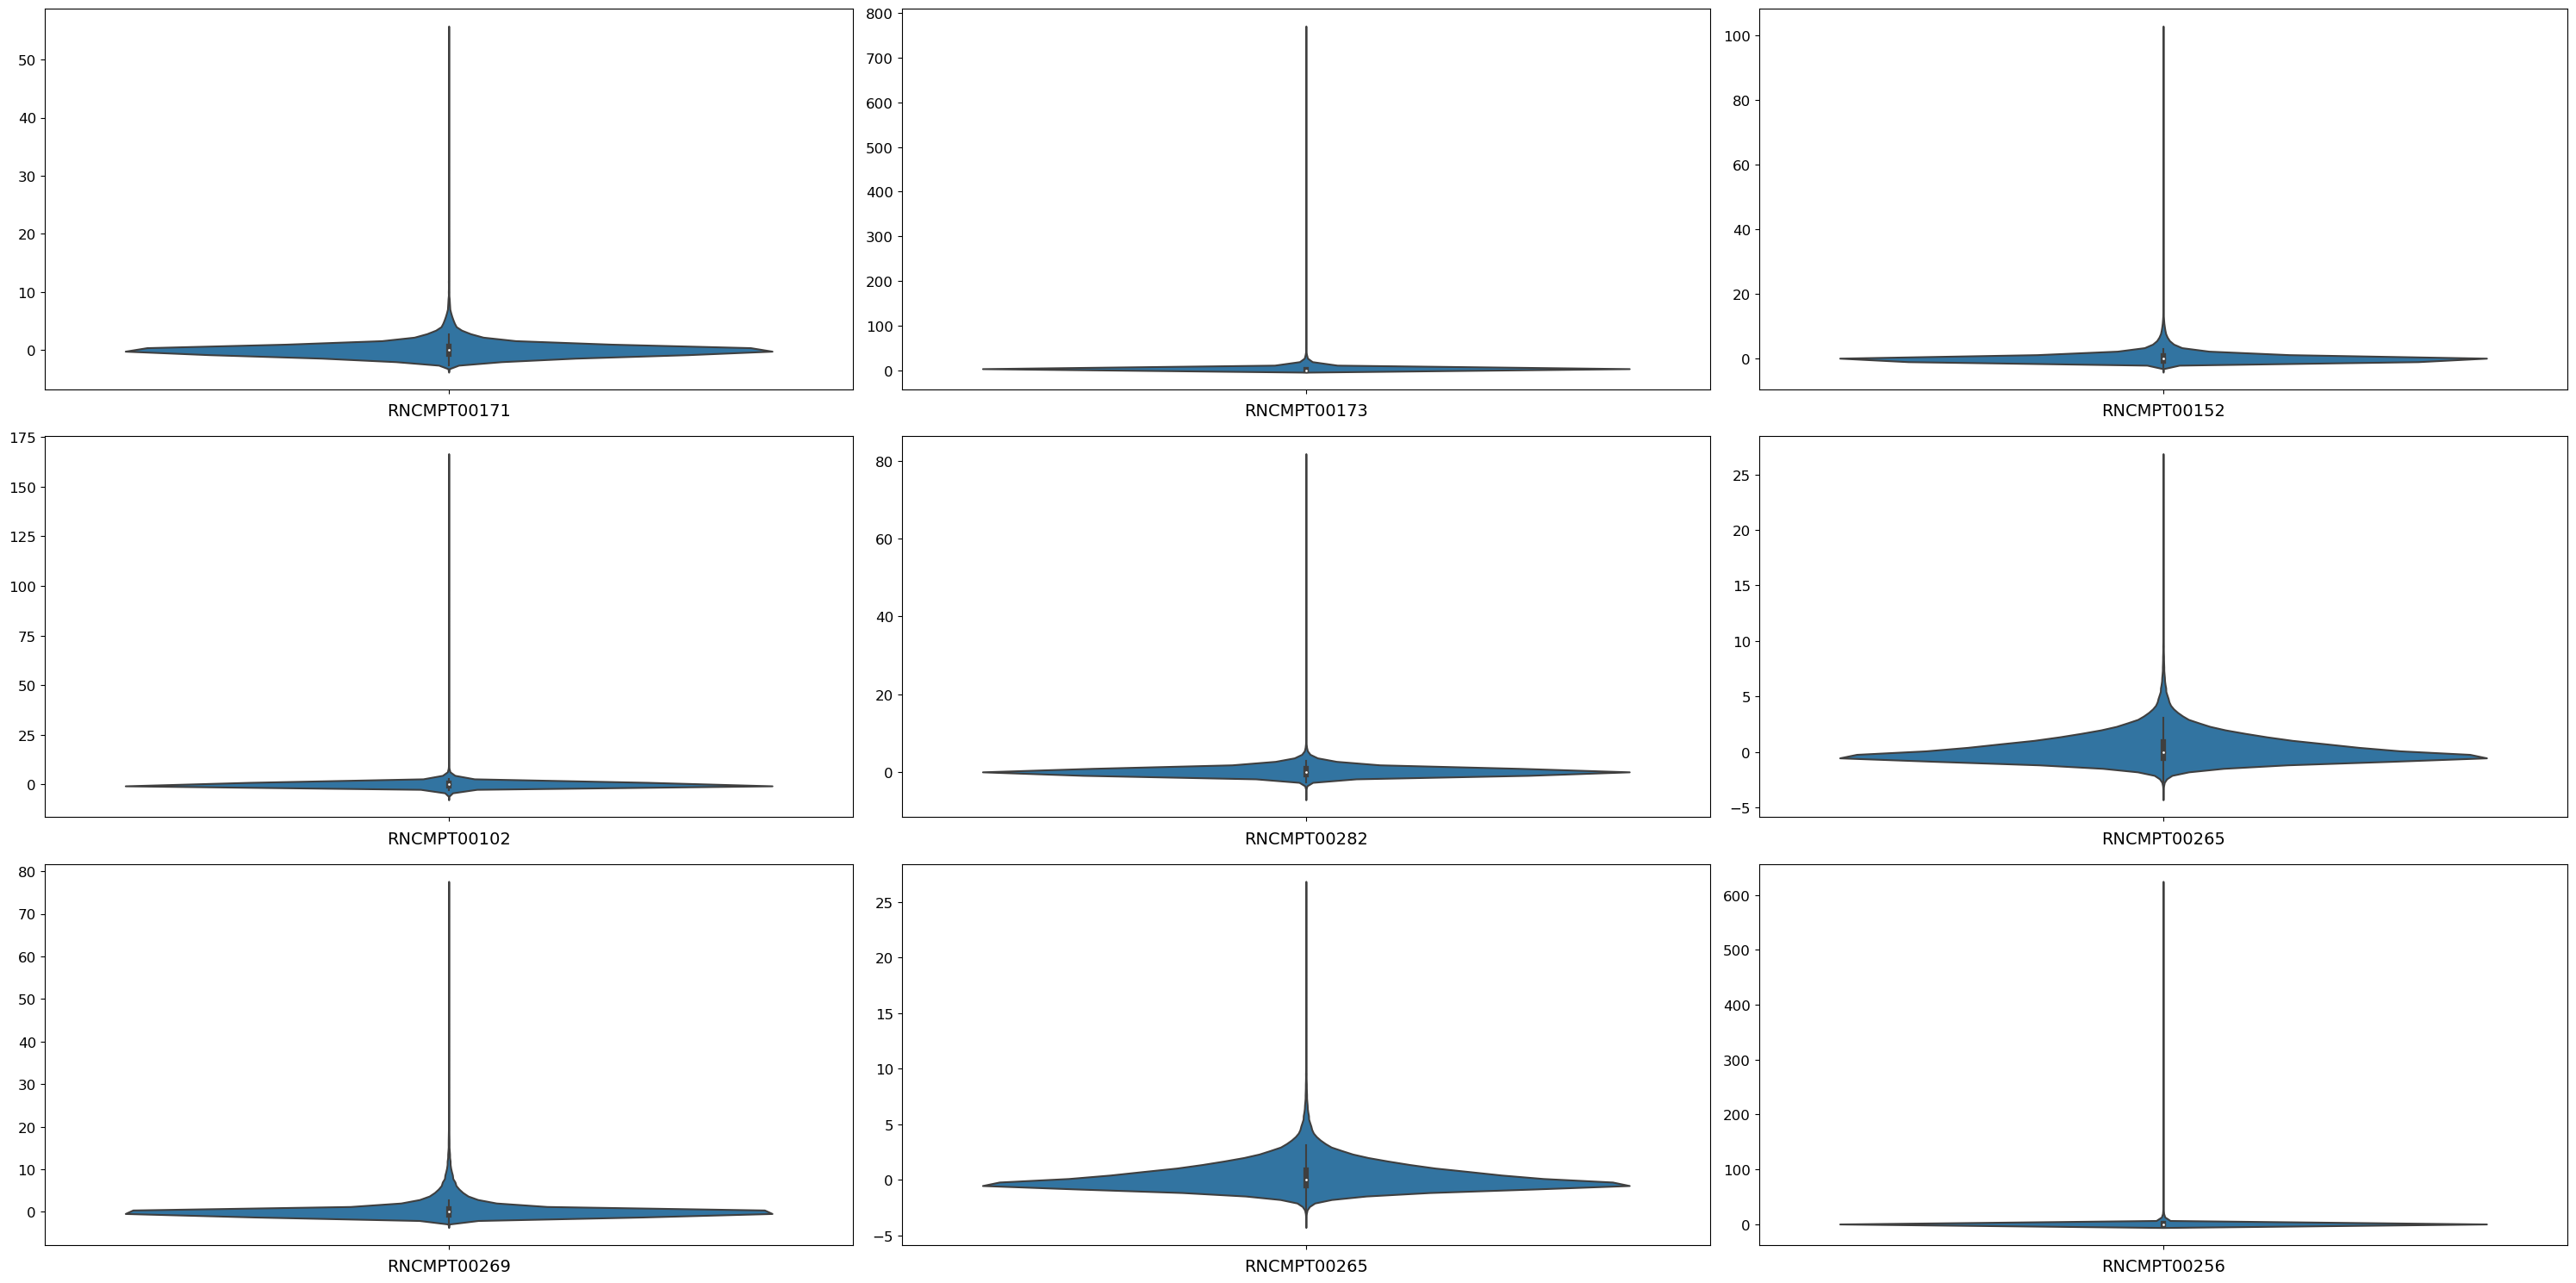

In [66]:
# Plot the distribution of the targets
eu.pl.violinplot(
    sdata_setA_raw, 
    keys=random_cols
)

In [67]:
# Clamp the targets based on percentiles
eu.pp.clamp_percentiles(sdata_setA_raw, percentile=0.9995, target_list=target_cols, train_key="train_val", store_clamp_nums=True)

In [68]:
sdata_setA_raw.seqs_annot[random_cols].describe()

,RNCMPT00171,RNCMPT00173,RNCMPT00152,RNCMPT00102,RNCMPT00282,RNCMPT00265,RNCMPT00269,RNCMPT00265,RNCMPT00256
count,119721.000000,119711.000000,119685.000000,120285.000000,120290.000000,120305.000000,120293.000000,120305.000000,120324.000000
mean,0.124251,0.582662,0.373224,0.093679,0.130696,0.310558,0.448059,0.310558,0.625455
std,1.342147,2.497996,1.720122,1.347374,1.204133,1.334342,2.154263,1.334342,2.731718
min,-3.531280,-3.508293,-3.830515,-7.433480,-6.962918,-4.032753,-3.277932,-4.032753,-5.270534
25%,-0.670640,-0.604705,-0.594493,-0.644934,-0.610096,-0.560087,-0.654291,-0.560087,-0.588832
50%,-0.001614,-0.002136,0.001540,-0.002511,-0.000390,0.000021,0.001833,0.000021,0.000231
75%,0.675690,0.806752,0.822466,0.716099,0.791143,0.911206,0.698343,0.911206,0.835048
max,11.752211,31.576341,19.383015,14.214153,8.341554,10.620990,23.819023,10.620990,35.200840


In [69]:
sdata_setA_raw.uns["clamp_nums"][random_cols]

RNCMPT00171    11.752211
RNCMPT00173    31.576341
RNCMPT00152    19.383015
RNCMPT00102    14.214153
RNCMPT00282     8.341554
RNCMPT00265    10.620990
RNCMPT00269    23.819023
RNCMPT00265    10.620990
RNCMPT00256    35.200840
Name: 0.9995, dtype: float64

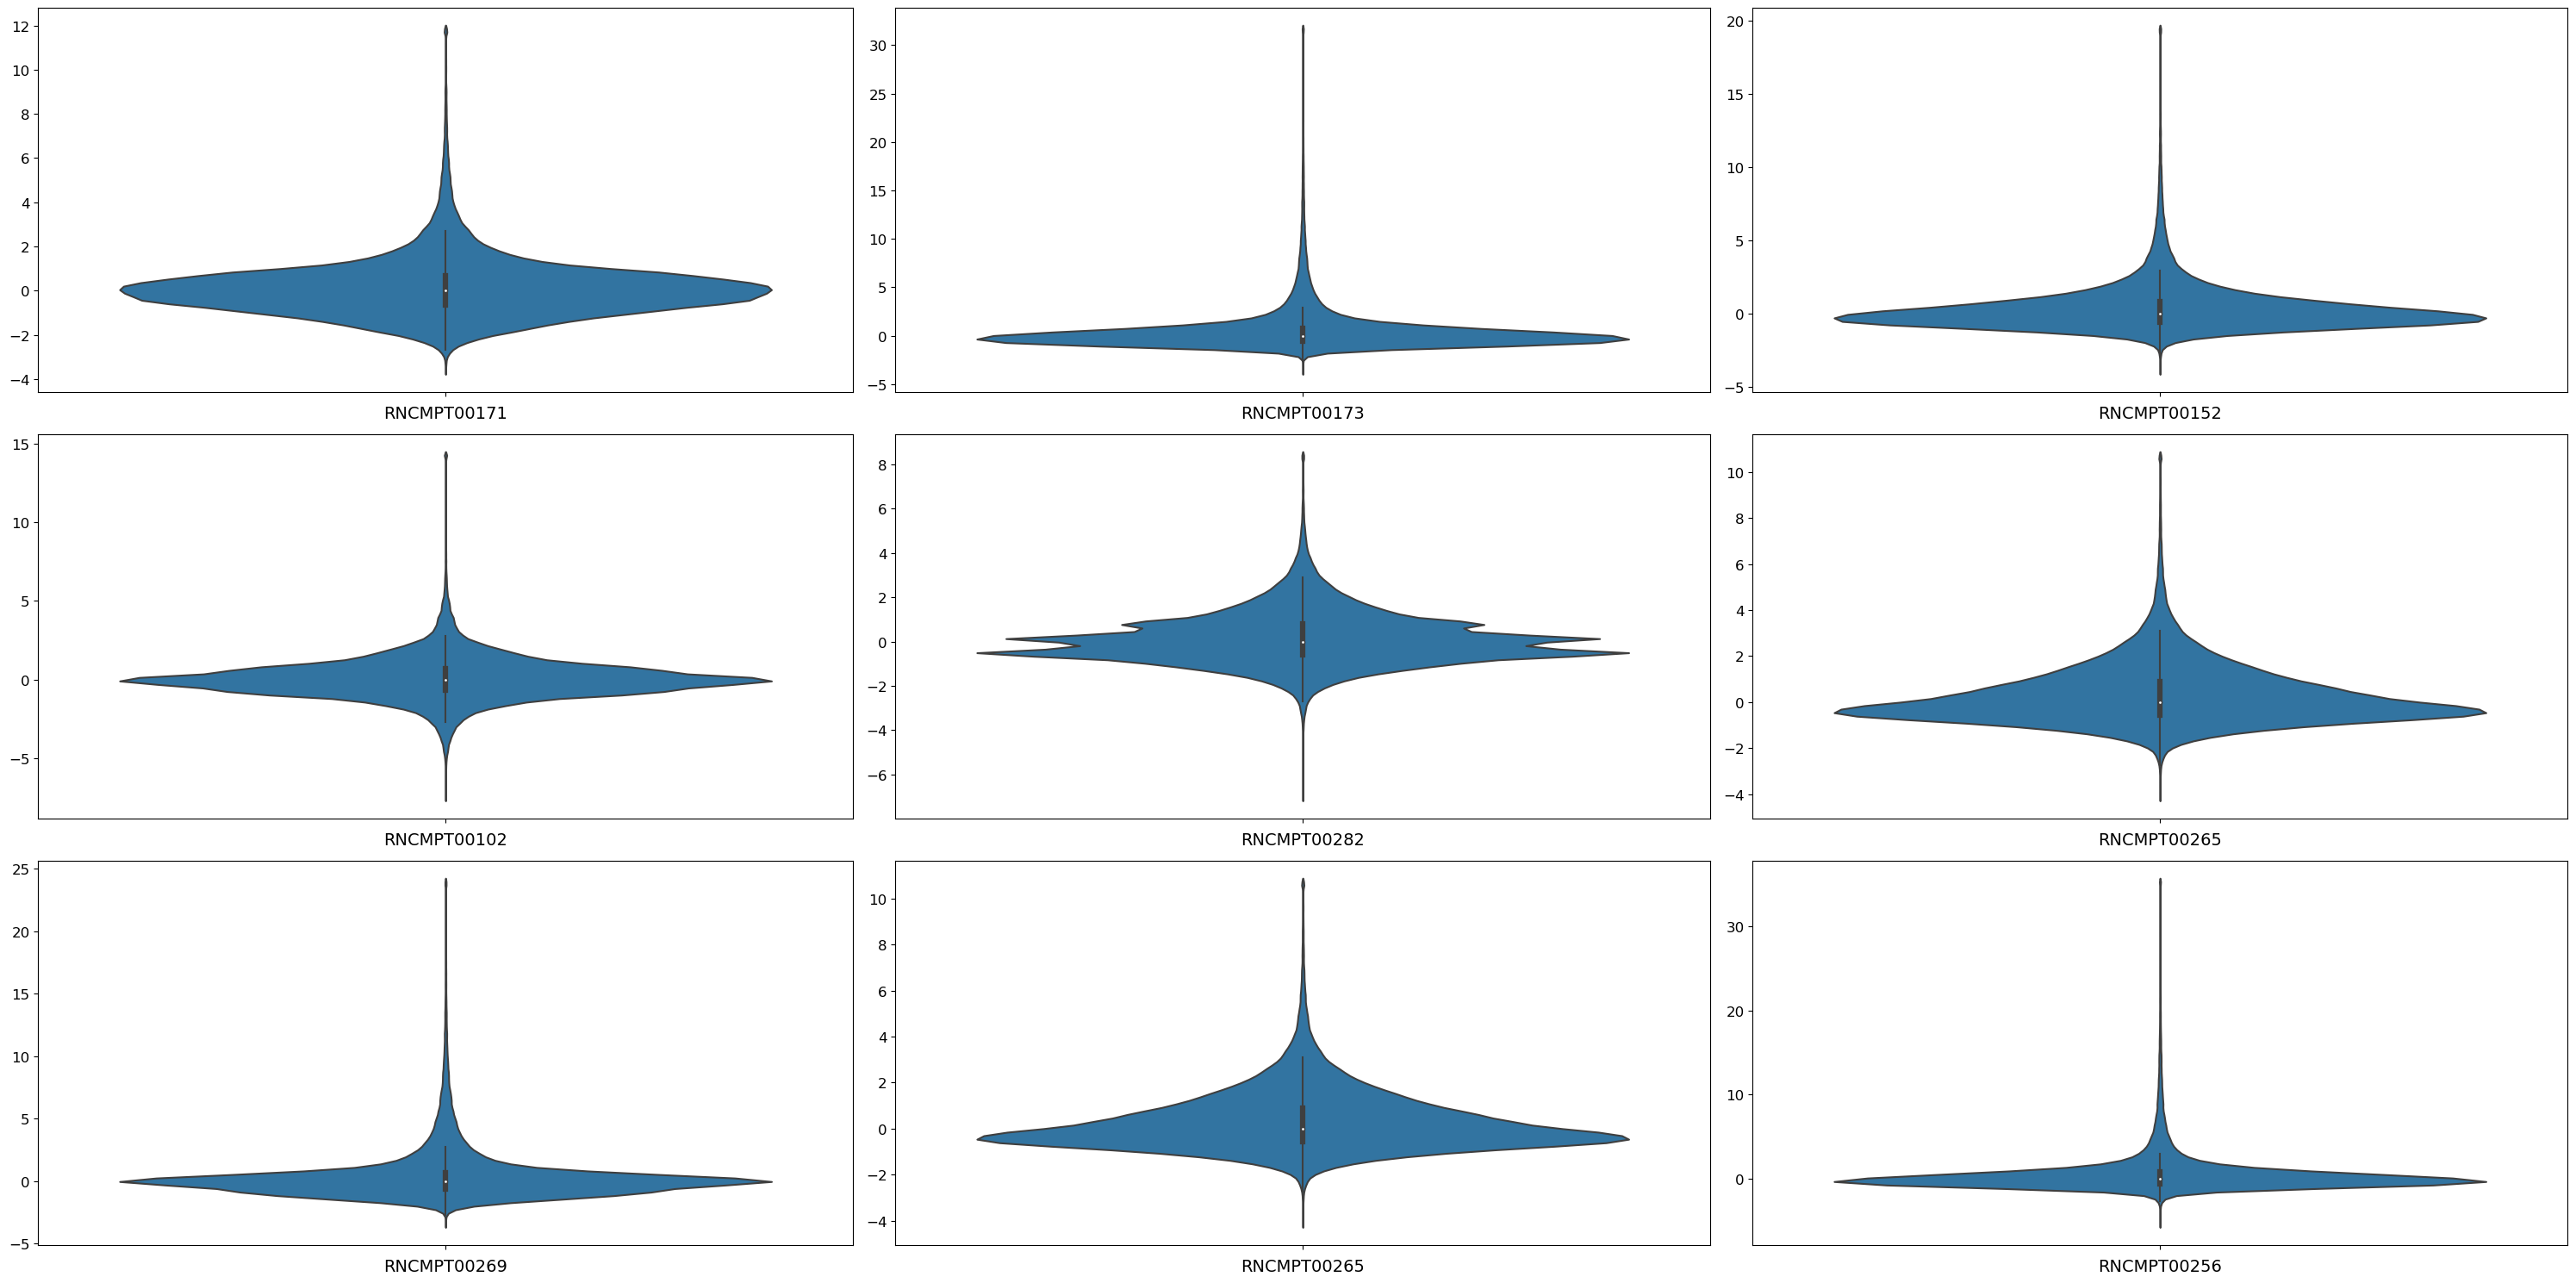

In [70]:
eu.pl.violinplot(
    sdata_setA_raw, 
    keys=random_cols
)

In [71]:
eu.pp.scale_targets(sdata_setA_raw, targets=target_cols, train_key="train_val", suffix=False, store_scaler=True)

In [72]:
sdata_setA_raw.seqs_annot[target_cols].describe()

,RNCMPT00100,RNCMPT00101,RNCMPT00102,RNCMPT00103,RNCMPT00104,RNCMPT00105,RNCMPT00106,RNCMPT00107,RNCMPT00108,RNCMPT00109,...,RNCMPT00008,RNCMPT00090,RNCMPT00091,RNCMPT00093,RNCMPT00094,RNCMPT00095,RNCMPT00096,RNCMPT00097,RNCMPT00099,RNCMPT00009
count,120252.000000,120262.000000,120285.000000,120313.000000,120313.000000,120179.000000,120279.000000,120316.000000,120304.000000,120304.000000,...,79089.000000,120324.000000,119649.000000,120326.000000,120254.000000,120213.000000,120319.000000,118832.000000,120168.000000,74561.000000
mean,-0.000892,0.001110,-0.000894,-0.001209,-0.000981,-0.000830,0.000346,0.000853,0.002044,0.001766,...,0.000686,-0.000100,0.000048,-0.002575,-0.001236,-0.000512,-0.001675,-0.001018,-0.000980,0.003283
std,0.997410,1.020525,1.002307,0.978627,0.982749,0.998109,1.000649,1.005483,1.010201,1.009679,...,1.000385,1.001129,1.002171,0.983708,0.994508,0.986762,0.986130,0.991359,0.996083,0.998293
min,-0.708462,-0.514076,-5.600323,-1.232183,-1.532100,-4.710454,-0.407043,-0.383484,-0.450989,-0.354403,...,-2.861418,-11.530205,-2.247183,-0.734555,-2.070196,-0.839285,-0.888454,-0.709476,-1.016065,-6.098262
25%,-0.333029,-0.186311,-0.550346,-0.254521,-0.289589,-0.487386,-0.223169,-0.229103,-0.250207,-0.219683,...,-0.540149,-0.316775,-0.596122,-0.276718,-0.499617,-0.253152,-0.261539,-0.237884,-0.308991,-0.607111
50%,-0.231536,-0.131478,-0.072450,-0.058678,-0.105945,-0.167116,-0.184461,-0.192930,-0.202766,-0.182754,...,-0.160582,-0.033841,-0.130832,-0.135262,-0.143978,-0.134833,-0.115630,-0.168271,-0.174184,-0.008076
75%,-0.061493,-0.053698,0.462122,0.117865,0.142312,0.346754,-0.111788,-0.125165,-0.120029,-0.114832,...,0.328262,0.295650,0.309110,0.025993,0.271894,0.027540,0.039491,-0.044344,0.008478,0.604184
max,16.246738,24.719098,10.503280,27.510587,28.689711,9.518592,19.219405,17.907541,17.026719,19.135278,...,10.981691,15.103138,9.182879,22.778451,18.856346,29.993462,24.794541,22.160394,19.009158,5.143852


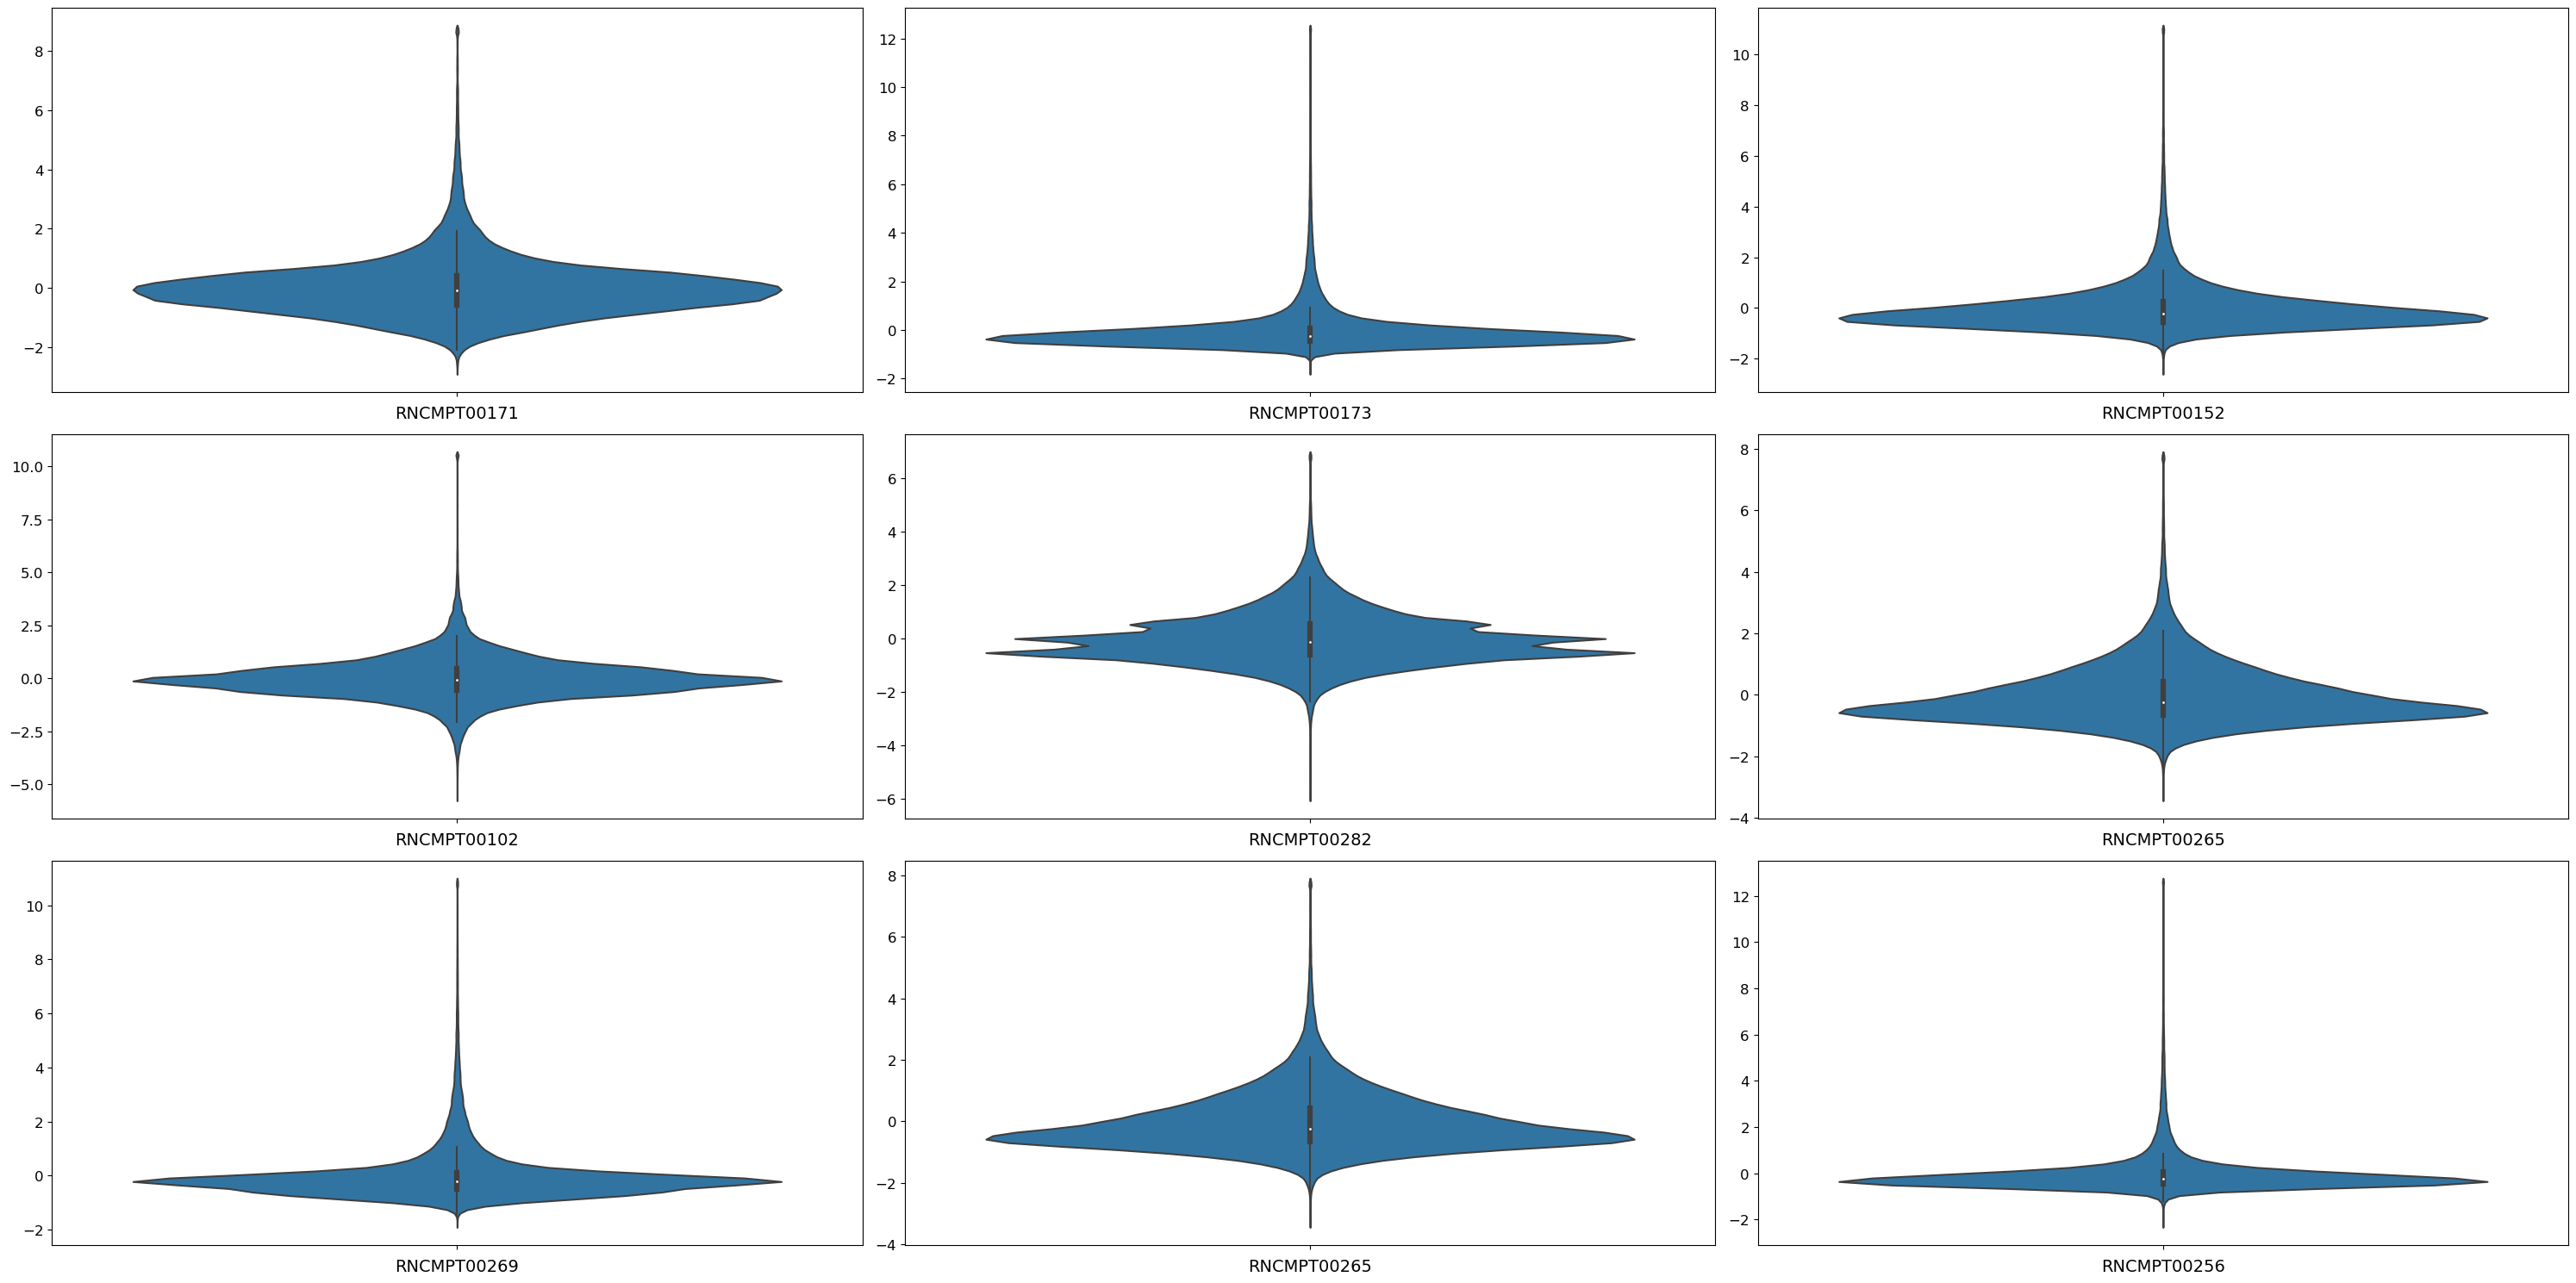

In [73]:
eu.pl.violinplot(
    sdata_setA_raw, 
    keys=random_cols
)

# Preprocess the test set

In [74]:
eu.pp.clamp_percentiles(sdata_setB_raw, target_list=target_cols, clamp_nums=sdata_setA_raw.uns["clamp_nums"])

In [75]:
sdata_setB_raw.seqs_annot[random_cols].describe()

,RNCMPT00171,RNCMPT00173,RNCMPT00152,RNCMPT00102,RNCMPT00282,RNCMPT00265,RNCMPT00269,RNCMPT00265,RNCMPT00256
count,120395.000000,120380.000000,120355.000000,120978.000000,121005.000000,121007.000000,121005.000000,121007.000000,121024.000000
mean,0.136595,0.584679,0.375651,0.100393,0.133678,0.315494,0.441216,0.315494,0.625072
std,1.362186,2.500706,1.739717,1.350311,1.201029,1.347292,2.123154,1.347292,2.732777
min,-3.531722,-3.480795,-3.759927,-7.031921,-6.736018,-4.278715,-3.312432,-4.278715,-5.836060
25%,-0.667104,-0.600845,-0.594125,-0.639498,-0.604086,-0.559615,-0.650844,-0.559615,-0.585180
50%,0.001233,0.002437,-0.001407,0.000202,0.000574,0.000030,-0.001978,0.000030,-0.000453
75%,0.684956,0.809123,0.817520,0.734612,0.790532,0.913099,0.697106,0.913099,0.837695
max,11.752211,31.576341,19.383015,14.214153,8.341554,10.620990,23.819023,10.620990,35.200840


In [76]:
eu.pp.scale_targets(sdata_setB_raw, targets=target_cols, scaler=sdata_setA_raw.uns["scaler"], suffix=False)

In [77]:
sdata_setB_raw.seqs_annot[random_cols].describe()

,RNCMPT00171,RNCMPT00173,RNCMPT00152,RNCMPT00102,RNCMPT00282,RNCMPT00265,RNCMPT00269,RNCMPT00265,RNCMPT00256
count,120395.000000,120380.000000,120355.000000,120978.000000,121005.000000,121007.000000,121005.000000,121007.000000,121024.000000
mean,0.009022,-0.001452,-0.001531,0.004101,0.000943,0.000838,-0.004660,0.000838,-0.003182
std,1.015916,0.997137,1.004167,1.004492,0.996482,1.008787,0.982119,1.008787,0.993850
min,-2.726803,-1.622528,-2.388592,-5.301604,-5.698777,-3.439084,-1.741005,-3.439084,-2.352951
25%,-0.590375,-0.474170,-0.561287,-0.546302,-0.611172,-0.654402,-0.509820,-0.654402,-0.443324
50%,-0.091931,-0.233617,-0.219170,-0.070431,-0.109492,-0.235366,-0.209670,-0.235366,-0.230672
75%,0.417989,0.088043,0.253516,0.475894,0.545929,0.448296,0.113709,0.448296,0.074144
max,8.671929,12.356229,10.969541,10.503280,6.810939,7.717096,10.809341,7.717096,12.571248


In [78]:
sdata_setA_raw.write_h5sd(os.path.join(eu.settings.dataset_dir, eu.settings.dataset_dir, "ray13", "norm_setA_processed.h5sd"))
sdata_setB_raw.write_h5sd(os.path.join(eu.settings.dataset_dir, eu.settings.dataset_dir, "ray13", "norm_setB_processed.h5sd"))

Unsupported type for scaler
Unsupported type for scaler


# Generating a presence/absence matrix per probe

In [34]:
from eugene.predict._metrics import generate_all_possible_kmers, kmer_in_seqs

In [36]:
a_probes = pd.Series(sdata_setA_raw.seqs)
b_probes = pd.Series(sdata_setB_raw.seqs)
kmers = generate_all_possible_kmers(n=7, alphabet="ACGU")
len(a_probes), len(b_probes), len(kmers)

(120326, 121031, 16384)

In [37]:
a_hits = np.array([a_probes.str.contains(kmer).astype(int).values for i, kmer in tqdm(enumerate(kmers), desc="Searching for kmers in probes", total=len(kmers))])
np.save(os.path.join(eu.settings.dataset_dir, "ray13", "SetA_binary"), a_hits)
a_hits.shape, np.all((a_hits == 1).sum(axis=1) >= 155)

Searching for kmers in probes:   0%|          | 0/16384 [00:00<?, ?it/s]

: 

: 

In [ ]:
b_hits = np.array([b_probes.str.contains(kmer).astype(int).values for i, kmer in tqdm(enumerate(kmers), desc="Searching for kmers in probes", total=len(kmers))])
np.save(os.path.join(eu.settings.dataset_dir, "ray13", "SetB_binary"), b_hits)
b_hits.shape,  np.all((b_hits == 1).sum(axis=1) >= 155)

Searching for kmers in probes:   0%|          | 0/16384 [00:00<?, ?it/s]

# Generate multitask ready data

In [79]:
nan_percents = sdata_setA_raw.seqs_annot[target_cols].isna().sum(axis=0).sort_values(ascending=False)/sdata_setA_raw.seqs_annot.shape[0]

In [80]:
remove_cols = nan_percents[nan_percents > 0.01].index
keep_cols = target_cols.drop(remove_cols)

In [81]:
sdata_setA_raw.seqs_annot = sdata_setA_raw.seqs_annot.drop(remove_cols, axis=1)

In [82]:
keep_rows = np.where(sdata_setA_raw.seqs_annot[keep_cols].isna().sum(axis=1) == 0)[0]
sdata_setA_MT = sdata_setA_raw[keep_rows]

In [83]:
sdata_setB_raw.seqs_annot = sdata_setB_raw.seqs_annot.drop(remove_cols, axis=1)

In [84]:
sdata_setA_MT.seqs_annot.shape, sdata_setB_raw.seqs_annot.shape

((110645, 235), (121031, 234))

In [94]:
sdata_setA_MT.seqs_annot[keep_cols].isna().sum().sum()

0

In [95]:
sdata_setA_MT.write_h5sd(os.path.join(eu.settings.dataset_dir, eu.settings.dataset_dir, "ray13", "norm_setA_processed_MT.h5sd"))
sdata_setB_raw.write_h5sd(os.path.join(eu.settings.dataset_dir, eu.settings.dataset_dir, "ray13", "norm_setB_processed_MT.h5sd"))

Unsupported type for scaler
Unsupported type for scaler


---

# Scratch

In [32]:
sdata.seqs_annot.isna().sum(axis=1).sort_values(ascending=False)[:20]

seq133747    104
seq117002    103
seq092826    102
seq124203    102
seq061395    102
seq195223    102
seq113624    102
seq146323    101
seq093392    101
seq044638    100
seq088282    100
seq036382    100
seq083383    100
seq010609    100
seq005807    100
seq198815     99
seq171734     99
seq000748     99
seq233144     99
seq162007     99
dtype: int64